In [29]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Project 1. CatFaceGAN - Generating Realistic Cat Faces with GANs

In [30]:
# Data Loading and Preprocessing Function
def load_and_preprocess_data(data_path, num_images):
    """
    Loads and preprocesses a specified number of images from a directory.

    This function lists all images in a given directory, shuffles them to ensure random selection,
    and processes a specified number of images. Each image is loaded, decoded, resized to 64x64 pixels,
    and normalized to have pixel values in the range [-1, 1]. The processed images are then batched
    and returned as a TensorFlow dataset.

    Args:
        data_path (str): The file path to the directory containing images.
        num_images (int): The number of images to load and preprocess.

    Returns:
        tf.data.Dataset: A TensorFlow dataset object containing the preprocessed and batched images.

    Raises:
        ValueError: If `num_images` is less than or equal to 0.
    """
    if num_images <= 0:
        raise ValueError("num_images must be greater than 0")

    # List all files in the data_path
    all_files = [os.path.join(data_path, fname) for fname in os.listdir(data_path)]
    # Shuffle the list if you want random images
    np.random.shuffle(all_files)
    # Select the first num_images images
    selected_files = all_files[:num_images]
    
    # Load and preprocess the images
    def preprocess_image(image_path):
        # Read the image
        image = tf.io.read_file(image_path)
        # Decode the image
        image = tf.image.decode_jpeg(image, channels=3)
        # Resize the image
        image = tf.image.resize(image, [64, 64])
        # Normalize the image to [-1, 1]
        image = (image - 127.5) / 127.5
        return image

    # Create a dataset from the selected files
    dataset = tf.data.Dataset.from_tensor_slices(selected_files)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # Batch the dataset
    dataset = dataset.batch(32)

    return dataset

In [31]:
# Generator function
def build_generator():
    """
    Builds a generator model using the Keras Sequential API.

    This function constructs a generator model that can be used in a Generative Adversarial Network (GAN)
    to generate 64x64 pixel images from a random noise vector. The model uses a series of layers, including
    dense, batch normalization, leaky ReLU activations, and transposed convolutions, to upscale the input noise
    vector to the final image size and shape.

    The architecture starts with a Dense layer to project and reshape the input noise vector, followed by a sequence
    of Conv2DTranspose layers to upscale the image to the desired resolution. Batch normalization and LeakyReLU
    activations are used throughout to stabilize training and encourage gradient flow.

    Returns:
        Sequential: The generator model, which takes a 100-dimensional noise vector as input and outputs a 64x64x3
        RGB image with pixel values normalized to the range [-1, 1].

    Example:
        >>> generator = build_generator()
        >>> noise = tf.random.normal([1, 100])  # Generate a batch of 1 noise vector.
        >>> generated_image = generator(noise, training=False)
        >>> print(generated_image.shape)
        (1, 64, 64, 3)
    """
    model = tf.keras.Sequential([
        # Start with a Dense layer that maps the input noise vector to a larger connected layer
        layers.Dense(16*16*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Reshape the output into something that can be upscaled to 64x64x3
        layers.Reshape((16, 16, 256)),
        # Upsample to 32x32
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        # Upsample to 64x64
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        # Output layer to produce 64x64x3 images, using tanh activation
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    
    return model


In [32]:
# Discriminator function
def build_discriminator():
    """
    Builds a discriminator model using the Keras Sequential API.

    This function assembles a discriminator model for use in a Generative Adversarial Network (GAN).
    The model is a convolutional neural network (CNN) that takes an image as input and outputs a single
    scalar representing the probability that the input image is real (as opposed to being generated by
    the generator component of the GAN).

    The architecture consists of a sequence of Conv2D layers with LeakyReLU activation and Dropout,
    followed by a Flatten layer and a final Dense layer. The Conv2D layers progressively downsample the
    image, allowing the model to learn spatial hierarchies of features. Dropout is used to help prevent
    overfitting to the training data by randomly dropping out units in the network during training.

    Returns:
        Sequential: The discriminator model, which takes a 64x64x3 RGB image as input and outputs a single
        scalar probability that the image is real.

    Example:
        >>> discriminator = build_discriminator()
        >>> decision = discriminator(generated_image)
        >>> print(decision)
    """
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    
    return model

In [33]:
# GAN model
def train(dataset, epochs, noise_dim=100, batch_size=32, display_interval=200):
    """
    Trains a GAN model for a specified number of epochs.

    This function sets up and trains a GAN composed of a generator and discriminator model. The training
    process involves feeding the generator random noise vectors to produce synthetic images, which along with
    real images from the provided dataset, are used to train the discriminator. The generator and discriminator
    compete against each other: the generator trying to produce increasingly realistic images, and the discriminator
    striving to get better at distinguishing real images from generated ones. Training involves backpropagation and
    optimization of both models' weights based on binary cross-entropy loss.

    Args:
        dataset (tf.data.Dataset): The dataset of real images for training the discriminator.
        epochs (int): The total number of epochs for training.
        noise_dim (int, optional): The dimension of the noise vector for the generator. Defaults to 100.
        batch_size (int, optional): The batch size used for training. Defaults to 32.
        display_interval (int, optional): The interval (number of epochs) at which to display progress, including
            generated images and loss graphs. Defaults to 100.

    Note:
        This function also initializes the optimizer for both models and defines a `train_step` function to perform
        the backpropagation and optimization for a single batch. Additionally, it includes a utility function to
        generate and display images at specified intervals during training for progress visualization.
    """
    generator = build_generator()
    discriminator = build_discriminator()

    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
    
    # Initialize lists to store losses for plotting
    gen_loss_history = []
    disc_loss_history = []

    @tf.function
    def train_step(images, batch_size, noise_dim):
        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)

            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
            disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + cross_entropy(tf.zeros_like(fake_output), fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss

    # Function to generate and save images
    def generate_and_save_images(model, epoch, test_input):
        predictions = model(test_input, training=False)
        fig = plt.figure(figsize=(10, 5))
        for i in range(predictions.shape[0]):
            plt.subplot(2, 5, i+1)
            plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5).numpy())
            plt.axis('off')
        plt.suptitle(f'Epoch {epoch+1}')
        plt.show()

    # Seed for visual consistency, generating 10 images
    seed = tf.random.normal([10, noise_dim])

    for epoch in range(epochs):
        epoch_gen_loss_list = []
        epoch_disc_loss_list = []
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size, noise_dim)
            epoch_gen_loss_list.append(gen_loss)
            epoch_disc_loss_list.append(disc_loss)

        # Calculate and store the average loss for the epoch
        epoch_gen_loss = tf.reduce_mean(epoch_gen_loss_list)
        epoch_disc_loss = tf.reduce_mean(epoch_disc_loss_list)
        gen_loss_history.append(epoch_gen_loss)
        disc_loss_history.append(epoch_disc_loss)

        # Display generated images and plot training losses at specified intervals
        if (epoch + 1) % display_interval == 0:
            print(f"Epoch {epoch+1}, Generator Loss: {epoch_gen_loss}, Discriminator Loss: {epoch_disc_loss}")
            generate_and_save_images(generator, epoch, seed)
            
            # Plot the training losses
            plt.figure(figsize=(10, 5))
            plt.plot(gen_loss_history, label='Generator Loss')
            plt.plot(disc_loss_history, label='Discriminator Loss')
            plt.title(f'Training Losses up to Epoch {epoch+1}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

In [34]:
# Number of files in the directory
def count_images_in_directory(directory_path):
    """
    Counts the number of files in a given directory.
    
    Parameters:
    - directory_path (str): The path to the directory containing the image files.
    
    Returns:
    - int: The number of image files in the directory.
    """
    # List all files in the given directory
    files = os.listdir(directory_path)
    # Count and return the number of files
    return len(files)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-04-01 16:50:37.893839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 200, Generator Loss: 1.5105153322219849, Discriminator Loss: 0.9512994289398193


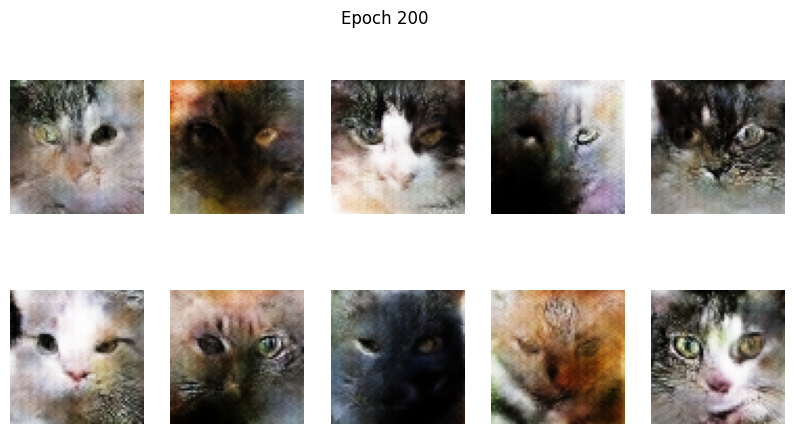

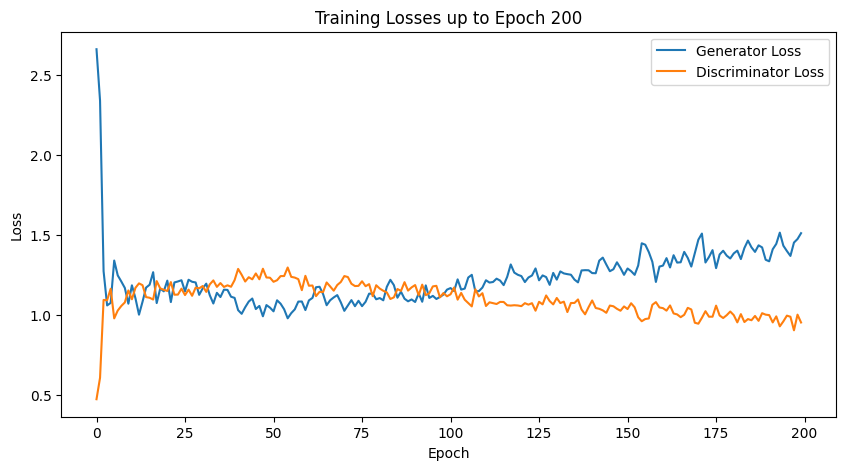

Epoch 400, Generator Loss: 1.6695802211761475, Discriminator Loss: 0.8334338665008545


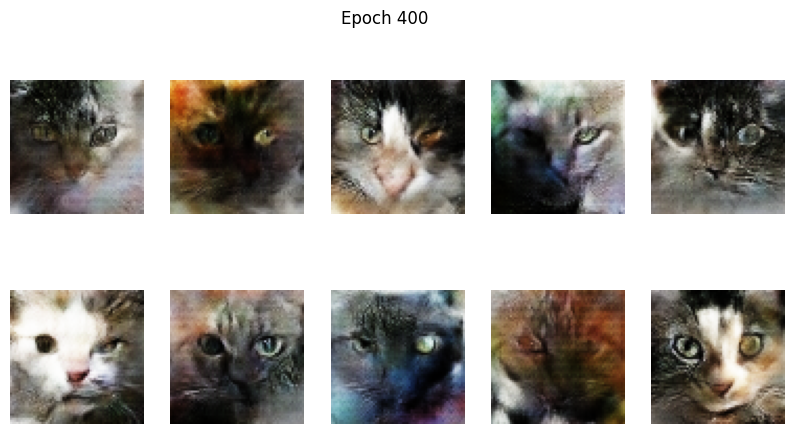

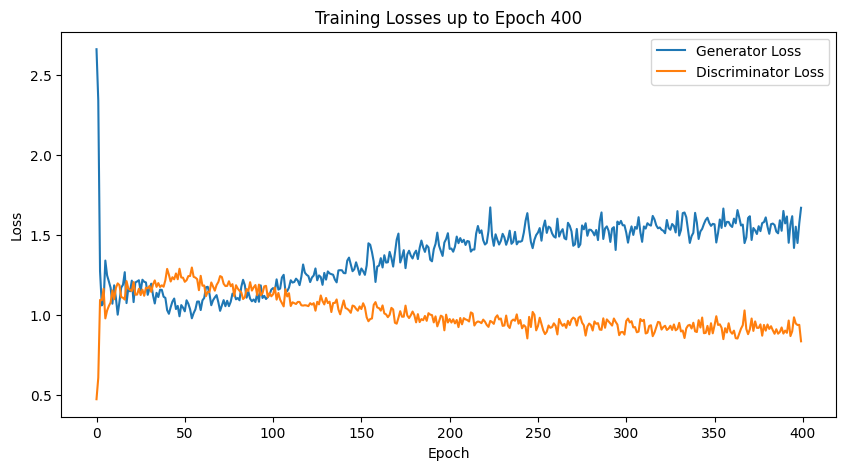

Epoch 600, Generator Loss: 1.5558773279190063, Discriminator Loss: 0.9402153491973877


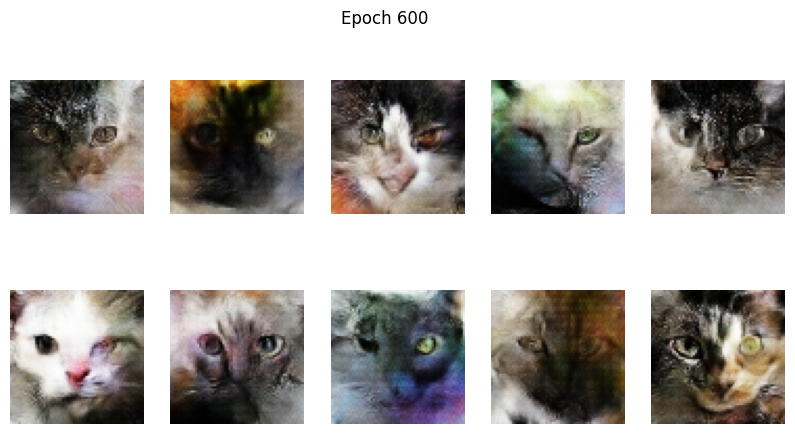

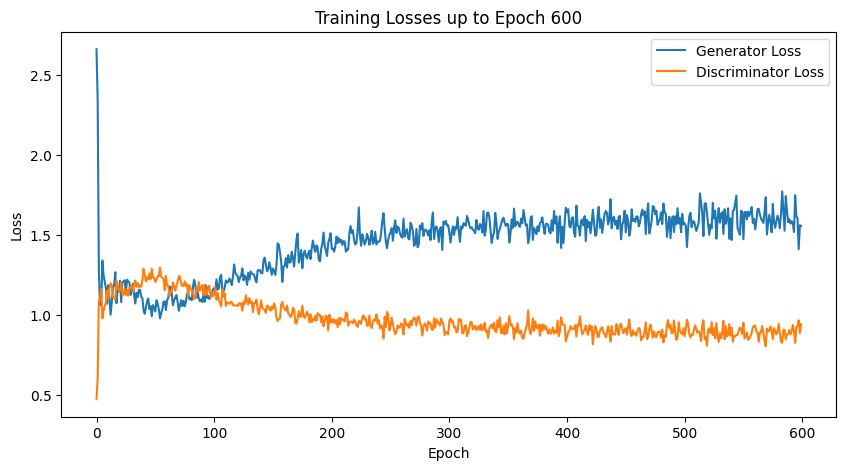

Epoch 800, Generator Loss: 1.5741997957229614, Discriminator Loss: 0.9026312232017517


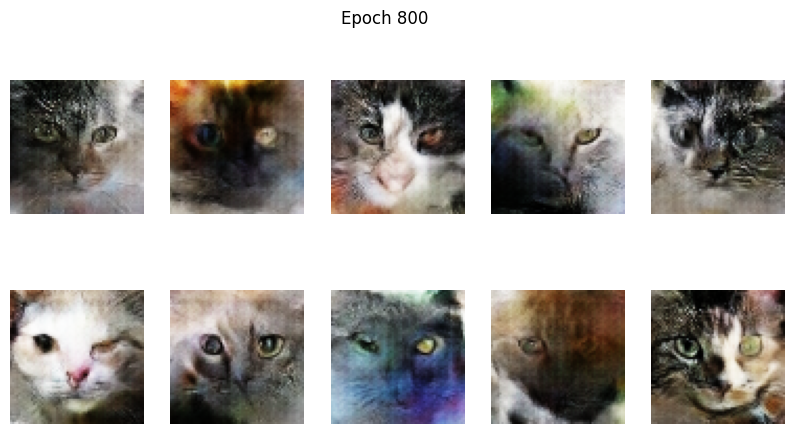

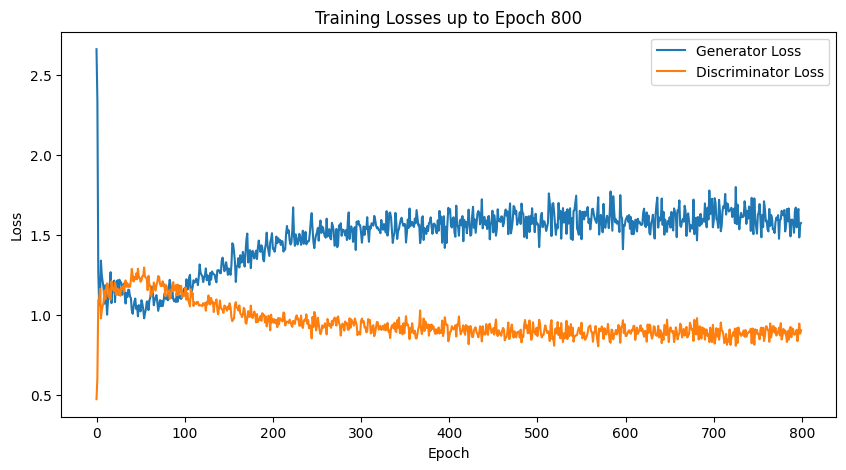

Epoch 1000, Generator Loss: 1.6248605251312256, Discriminator Loss: 0.8294681310653687


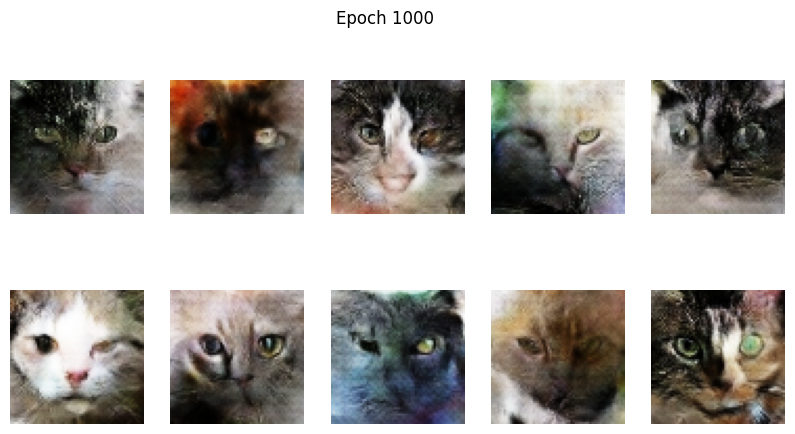

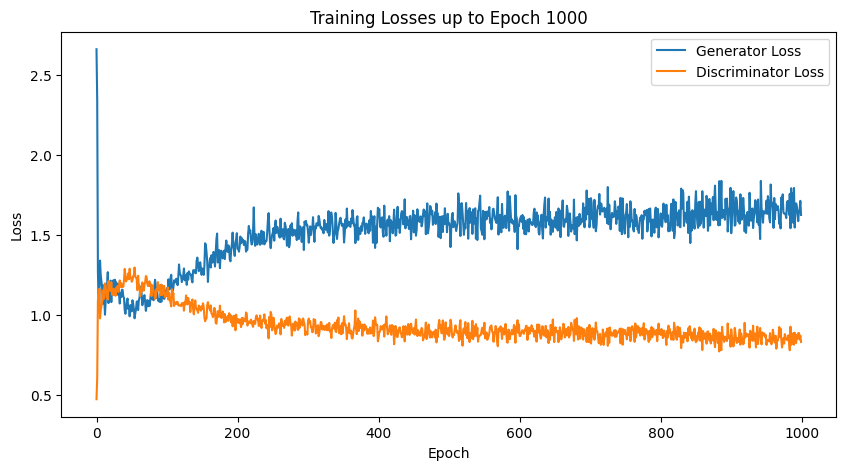

Epoch 1200, Generator Loss: 1.6543850898742676, Discriminator Loss: 0.9038523435592651


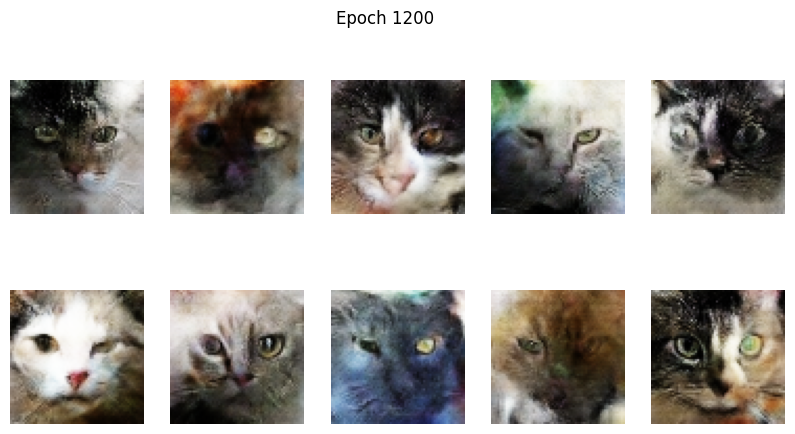

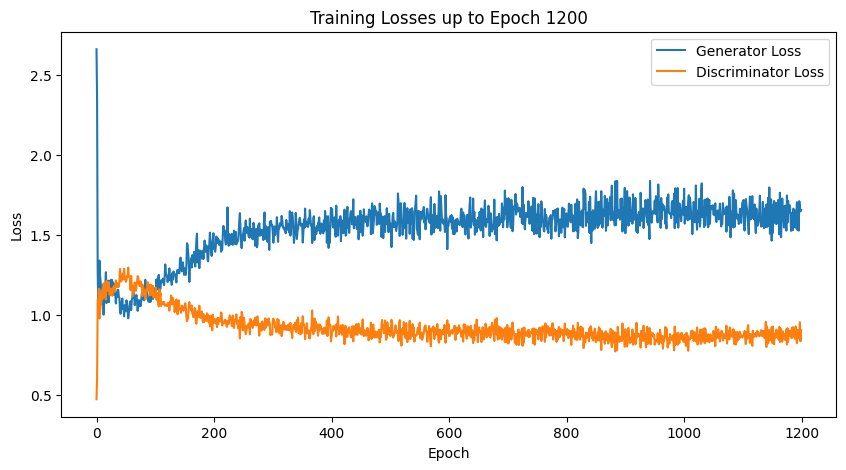

Epoch 1400, Generator Loss: 1.5981913805007935, Discriminator Loss: 0.8856322169303894


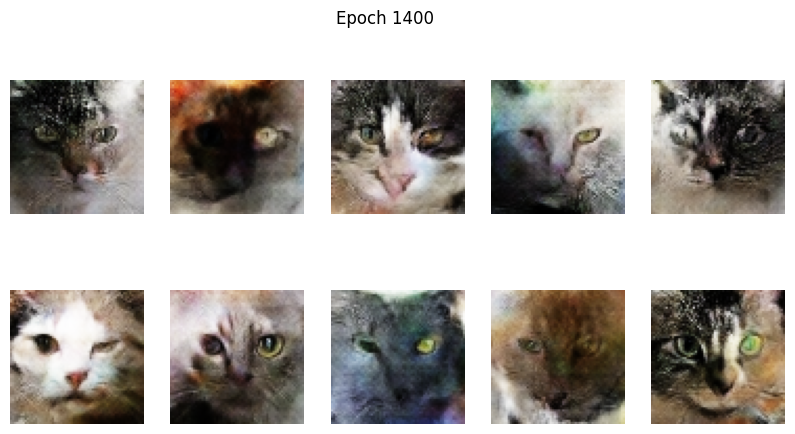

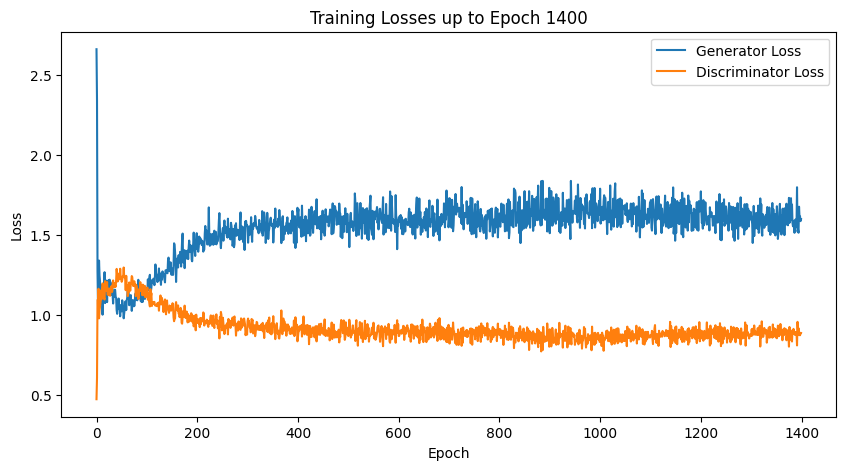

In [ ]:
# Training Loop and Image Generation
def main():
    """
    Main function to train a GAN on a dataset of cat images.

    This function performs several key steps to prepare for and initiate the training of a Generative
    Adversarial Network (GAN). It specifies the path to the dataset containing cat images, counts the
    number of images in the dataset, loads and preprocesses these images, and finally, trains the GAN
    model on this dataset for a specified number of epochs.

    The function assumes the existence of helper functions `count_images_in_directory` to
    count the images in the specified directory, and `load_and_preprocess_data` to load the images into
    a TensorFlow dataset with appropriate preprocessing for GAN training.

    """
    data_path = '../input/cats-faces-64x64-for-generative-models/cats/cats'  
    
    num_images = count_images_in_directory(data_path)
    dataset = load_and_preprocess_data(data_path, num_images)
    train(dataset, epochs=2000)  
    
if __name__ == "__main__":
    main()